In [1]:
import torch
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn as nn
import numpy as np
import json, time

from torch.nn.utils import parameters_to_vector as p2v

In [2]:
data_dir = "dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 8

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# plot the image
def show_image_prev(image_numpy_arr):
    fig, ax = plt.subplots()

    image = image_numpy_arr.transpose(1, 2, 0)
    print(image.shape)
    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<class 'torch.Tensor'>
torch.Size([8, 3, 224, 224])
torch.Size([8])
(224, 224, 3)


<Axes: >

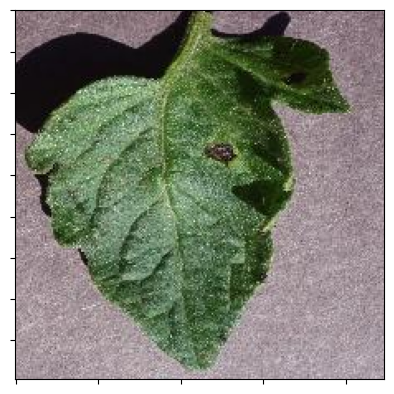

In [4]:
train_transforms = transforms.Compose([transforms.RandomRotation(30), #data augumnetation
                                       transforms.CenterCrop(IMAGE_SIZE),#resize
                                       #transforms.RandomResizedCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(), #data augumnetation
                                       transforms.ToTensor()])

val_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(IMAGE_SIZE), #resize
                                     #transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.RandomHorizontalFlip(), #data augumnetation
                                     transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)

dataiter = iter(train_loader)
images, classes = next(dataiter)
print(type(images))
print(images.shape)
print(classes.shape)

show_image_prev(np.array(images[0]))

In [5]:
(train_data.classes)

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
train_data.class_to_idx

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

## Calc dims through a conv layer

## $O = (\frac{W - K + 2P}{S}) + 1$

## Calc dims after a max pool layer

## $O = (\frac{W}{K})$

O - The output height/width\
W - The input height/width\
K - The kernel size\
P - Padding\
S - Stride

In [7]:
"""
#model v2

class CropDetectCNN3(nn.Module):
    # initialize the class and the parameters
    def __init__(self, inp_size: int, num_classes: int):
        super(CropDetectCNN3, self).__init__()
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((inp_size - 3 + 2*0)/1 + 1)
        O = int(O/2)
        
        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((O - 3 + 2*1)/2 + 1)
        O = int(O/2)

        #Fully connected layer
        self.fc = nn.Linear(32*O*O, num_classes)
        self.inp_size = inp_size
        self.out_size = O

         

    # Feed forward the network
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = CropDetectCNN3(IMAGE_SIZE, len(train_data.class_to_idx))
print(model)
"""

'\n#model v2\n\nclass CropDetectCNN3(nn.Module):\n    # initialize the class and the parameters\n    def __init__(self, inp_size: int, num_classes: int):\n        super(CropDetectCNN3, self).__init__()\n        # convolutional layer 1 & max pool layer 1\n        self.layer1 = nn.Sequential(\n            nn.Conv2d(3, 16, kernel_size=3),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2)\n        )\n\n        O = int((inp_size - 3 + 2*0)/1 + 1)\n        O = int(O/2)\n        \n        # convolutional layer 2 & max pool layer 2\n        self.layer2 = nn.Sequential(\n            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2)\n        )\n\n        O = int((O - 3 + 2*1)/2 + 1)\n        O = int(O/2)\n\n        #Fully connected layer\n        self.fc = nn.Linear(32*O*O, num_classes)\n        self.inp_size = inp_size\n        self.out_size = O\n\n         \n\n    # Feed forward the net

In [8]:
"""
#model v3

class CropDetectCNN3(nn.Module):
    # initialize the class and the parameters
    def __init__(self, inp_size: int, num_classes: int):
        super(CropDetectCNN3, self).__init__()
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((inp_size - 3 + 2*0)/1 + 1)
        O = int(O/2)
        
        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((O - 3 + 2*1)/2 + 1)
        O = int(O/2)

        # convolutional layer 2 & max pool layer 2
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((O - 3 + 2*1)/2 + 1)
        O = int(O/2)

        #Fully connected layer
        self.fc = nn.Linear(64*O*O, num_classes)
        self.inp_size = inp_size
        self.out_size = O

         

    # Feed forward the network
    def forward(self, x):
        out = self.layer1(x)
        #print("layer1 out:", out.size())
        out = self.layer2(out)
        #print("layer2 out:", out.size())
        out = self.layer3(out)
        #print("layer3 out:", out.size())
        out = out.reshape(out.size(0), -1)
        #sprint("reshape out:", out.size())
        out = self.fc(out)
        return out

model = CropDetectCNN3(IMAGE_SIZE, len(train_data.class_to_idx))
print(model)
"""

'\n#model v3\n\nclass CropDetectCNN3(nn.Module):\n    # initialize the class and the parameters\n    def __init__(self, inp_size: int, num_classes: int):\n        super(CropDetectCNN3, self).__init__()\n        # convolutional layer 1 & max pool layer 1\n        self.layer1 = nn.Sequential(\n            nn.Conv2d(3, 16, kernel_size=3),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2)\n        )\n\n        O = int((inp_size - 3 + 2*0)/1 + 1)\n        O = int(O/2)\n        \n        # convolutional layer 2 & max pool layer 2\n        self.layer2 = nn.Sequential(\n            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2)\n        )\n\n        O = int((O - 3 + 2*1)/2 + 1)\n        O = int(O/2)\n\n        # convolutional layer 2 & max pool layer 2\n        self.layer3 = nn.Sequential(\n            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),\n            nn.ReLU(inplac

In [9]:
"""
#model v4

class CropDetectCNN3(nn.Module):
    # initialize the class and the parameters
    def __init__(self, inp_size: int, num_classes: int):
        super(CropDetectCNN3, self).__init__()
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((inp_size - 3 + 2*0)/1 + 1)
        O = int(O/2)
        
        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((O - 3 + 2*1)/2 + 1)
        O = int(O/2)

        # convolutional layer 2 & max pool layer 2
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        O = int((O - 3 + 2*1)/2 + 1)
        O = int(O/2)

        #Fully connected layer
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64*O*O, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        self.inp_size = inp_size
        self.out_size = O

         

    # Feed forward the network
    def forward(self, x):
        out = self.layer1(x)
        #print("layer1 out:", out.size())
        out = self.layer2(out)
        #print("layer2 out:", out.size())
        out = self.layer3(out)
        #print("layer3 out:", out.size())
        out = out.reshape(out.size(0), -1)
        #sprint("reshape out:", out.size())
        out = self.fc(out)
        return out

model = CropDetectCNN3(IMAGE_SIZE, len(train_data.class_to_idx))
print(model)
"""

'\n#model v4\n\nclass CropDetectCNN3(nn.Module):\n    # initialize the class and the parameters\n    def __init__(self, inp_size: int, num_classes: int):\n        super(CropDetectCNN3, self).__init__()\n        # convolutional layer 1 & max pool layer 1\n        self.layer1 = nn.Sequential(\n            nn.Conv2d(3, 16, kernel_size=3),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2)\n        )\n\n        O = int((inp_size - 3 + 2*0)/1 + 1)\n        O = int(O/2)\n        \n        # convolutional layer 2 & max pool layer 2\n        self.layer2 = nn.Sequential(\n            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2)\n        )\n\n        O = int((O - 3 + 2*1)/2 + 1)\n        O = int(O/2)\n\n        # convolutional layer 2 & max pool layer 2\n        self.layer3 = nn.Sequential(\n            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),\n            nn.ReLU(inplac

In [10]:
"""
#model v5

class CropDetectCNN3(nn.Module):
    # initialize the class and the parameters
    def __init__(self, inp_size: int, num_classes: int):
        super(CropDetectCNN3, self).__init__()
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding=1, stride=4),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3)
        )

        O = int(int((inp_size - 11 + 2*1)/4) + 1)
        O = int(O/3)
        
        self.layer2 = nn.Sequential(
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(64, 180, kernel_size=5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(180, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
        )

        #O = int((O - 1 + 2*0)/1 + 1)
        #O = int((O - 3 + 2*1)/1 + 1)
        #print("after serial: ", O)

        # convolutional layer 2 & max pool layer 2
        self.layer3 = nn.MaxPool2d(kernel_size=2)

        O = int(O/2)
        #print(O)
        #print("after layer3: ", O)

        #Fully connected layer
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*O*O, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes)
        )
        self.inp_size = inp_size
        self.out_size = O

         

    # Feed forward the network
    def forward(self, x):
        #xin = x
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        
        out = self.fc(out)
        return out

model = CropDetectCNN3(IMAGE_SIZE, len(train_data.class_to_idx))
print(model)"""

'\n#model v5\n\nclass CropDetectCNN3(nn.Module):\n    # initialize the class and the parameters\n    def __init__(self, inp_size: int, num_classes: int):\n        super(CropDetectCNN3, self).__init__()\n        # convolutional layer 1 & max pool layer 1\n        self.layer1 = nn.Sequential(\n            nn.Conv2d(3, 64, kernel_size=11, padding=1, stride=4),\n            #nn.BatchNorm2d(64, momentum=0.05, affine=True),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=3)\n        )\n\n        O = int(int((inp_size - 11 + 2*1)/4) + 1)\n        O = int(O/3)\n        \n        self.layer2 = nn.Sequential(\n            #nn.BatchNorm2d(64, momentum=0.05, affine=True),\n            nn.Conv2d(64, 180, kernel_size=5, padding=2, stride=1),\n            nn.ReLU(inplace=True),\n            #nn.BatchNorm2d(64, momentum=0.05, affine=True),\n            nn.Conv2d(180, 256, kernel_size=3, padding=1, stride=1),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(256, 128,

In [12]:
#model v6

class CropDetectCNN3(nn.Module):
    # initialize the class and the parameters
    def __init__(self, inp_size: int, num_classes: int):
        super(CropDetectCNN3, self).__init__()
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding=1, stride=4),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3)
        )

        O = int(int((inp_size - 11 + 2*1)/4) + 1)
        O = int(O/3)

        self.layer2_0 = nn.Sequential(
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(64, 175, kernel_size=7, padding=2, stride=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(175, 343, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(343, 128, kernel_size=3, padding=1, stride=1),
        )
        
        self.layer2_1 = nn.Sequential(
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(64, 180, kernel_size=5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(180, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=7, padding=2, stride=1),
        )

        O = int((O - 7 + 2*2)/1 + 1)
        #O = int((O - 3 + 2*1)/1 + 1)
        #print("after serial: ", O)

        # convolutional layer 2 & max pool layer 2
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=5, padding=2, stride=1),
        )

        O = int(O/2)
        print(O)
        #print("after layer3: ", O)

        #Fully connected layer
        self.fc = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128*O*O, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )
        self.inp_size = inp_size
        self.out_size = O

         

    # Feed forward the network
    def forward(self, x):
        #xin = x
        out = self.layer1(x)
        
        out1 = self.layer2_0(out)
        out = self.layer2_1(out)
        #print(out.shape)
        out = torch.cat([out1, out], 1)
        out = self.layer3(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        #raise
        
        out = self.fc(out)
        return out

model = CropDetectCNN3(IMAGE_SIZE, len(train_data.class_to_idx))
print(model)

8
CropDetectCNN3(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_0): Sequential(
    (0): Conv2d(64, 175, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(175, 343, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(343, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer2_1): Sequential(
    (0): Conv2d(64, 180, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(180, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  )
  (layer3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU(inplace=True

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [14]:
model.load_state_dict(torch.load("modelv6.torch", weights_only=True))

<All keys matched successfully>

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [101]:
valid_accuracy_track = []

In [102]:
epochs = 25 # run more iterations

start_time = time.time()
for epoch in range(epochs):
    running_loss = 0
    model.train()
    for images, classes in train_loader:
        # To device - to transfrom the image and classes to CPU|GPU
        images, classes = images.to(device), classes.to(device)
        
        # clears old gradients from the last step
        optimizer.zero_grad()

        # train the images
        outputs = model(images)
        #raise

        #calculate the loss given the outputs and the classes
        loss = criterion(outputs, classes)

        # compute the loss of every parameter
        loss.backward()

        # apply the optimizer and its parameters
        optimizer.step()

        #update the loss
        running_loss += loss.item()

    else: # doesnt run if i break out of loop
        validation_loss = 0
        accuracy = 0
        
        # to make the model run faster we are using the gradients on the train
        with torch.no_grad():
            # specify that this is validation and not training
            model.eval()
            for images, classes in val_loader:          
                # Use GPU
                images, classes = images.to(device), classes.to(device)
                
                # validate the images
                outputs = model(images)

                # compute validation loss
                loss = criterion(outputs, classes)

                #update loss
                validation_loss += loss.item()

                # get the exponential of the outputs
                ps = torch.exp(outputs)

                #Returns the k largest elements of the given input tensor along a given dimension.
                top_p, top_class = ps.topk(1, dim=1)

                # reshape the tensor
                equals = top_class == classes.view(*top_class.shape)

                # calculate the accuracy.
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # change the mode to train for the next epochs

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(val_loader))
             )
        valid_accuracy_track.append((accuracy/len(val_loader)).item())

end_time = time.time()
elapsed = end_time - start_time

Epoch: 1/25..  Training Loss: 2.284..  Valid Loss: 2.302..  Valid Accuracy: 0.107
Epoch: 2/25..  Training Loss: 2.177..  Valid Loss: 1.825..  Valid Accuracy: 0.359
Epoch: 3/25..  Training Loss: 1.652..  Valid Loss: 1.438..  Valid Accuracy: 0.481
Epoch: 4/25..  Training Loss: 1.223..  Valid Loss: 0.885..  Valid Accuracy: 0.693
Epoch: 5/25..  Training Loss: 0.884..  Valid Loss: 1.006..  Valid Accuracy: 0.649
Epoch: 6/25..  Training Loss: 0.680..  Valid Loss: 3.966..  Valid Accuracy: 0.265
Epoch: 7/25..  Training Loss: 0.543..  Valid Loss: 0.545..  Valid Accuracy: 0.802
Epoch: 8/25..  Training Loss: 0.456..  Valid Loss: 0.379..  Valid Accuracy: 0.870
Epoch: 9/25..  Training Loss: 0.391..  Valid Loss: 0.830..  Valid Accuracy: 0.769
Epoch: 10/25..  Training Loss: 0.324..  Valid Loss: 1.067..  Valid Accuracy: 0.703
Epoch: 11/25..  Training Loss: 0.290..  Valid Loss: 0.250..  Valid Accuracy: 0.910
Epoch: 12/25..  Training Loss: 0.253..  Valid Loss: 0.239..  Valid Accuracy: 0.917
Epoch: 13/25.

In [116]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["valid_accuracy"]["custom_cnn"] = valid_accuracy_track
stats["time_taken"]["custom_cnn"] = elapsed
stats["params"]["custom_cnn"] = p2v(model.parameters()).numel()

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

In [117]:
torch.save(model.state_dict(), "modelv6.torch")

In [16]:
model.class_to_idx = train_data.class_to_idx
model.class_to_idx.items()

dict_items([('Tomato___Bacterial_spot', 0), ('Tomato___Early_blight', 1), ('Tomato___Late_blight', 2), ('Tomato___Leaf_Mold', 3), ('Tomato___Septoria_leaf_spot', 4), ('Tomato___Spider_mites Two-spotted_spider_mite', 5), ('Tomato___Target_Spot', 6), ('Tomato___Tomato_Yellow_Leaf_Curl_Virus', 7), ('Tomato___Tomato_mosaic_virus', 8), ('Tomato___healthy', 9)])

In [17]:
# plot the image
def show_image(image_numpy_arr):
    fig, ax = plt.subplots()

    # convert the shape from (3, 256, 256) to (256, 256, 3)
    image = image_numpy_arr.transpose(1, 2, 0)

    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def process_image(image_path, show):
    test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.RandomRotation(30), transforms.RandomHorizontalFlip(), transforms.CenterCrop(IMAGE_SIZE), transforms.ToTensor()])
    #test_transform = transforms.Compose([transforms.RandomResizedCrop(IMAGE_SIZE), transforms.ToTensor()])
    if isinstance(image_path, str):
        image_path = Image.open(image_path)
        image_path = test_transform(image_path)
    if show: show_image(np.array(image_path))
    return image_path

In [18]:
def predict(image, model, show=True):
    with torch.no_grad():
        model.eval()
        image = process_image(image, show)
        image_inp = image.unsqueeze(0)
        
        image_inp = image_inp.to(device)
        
        outputs = model(image_inp)
    ps = torch.nn.functional.softmax(outputs, dim=1)

    top_p, top_cls = ps.topk(5, dim=1)
    top_cls = top_cls.cpu().numpy().tolist()[0]

    idx_to_class = {v: k for k, v in model.class_to_idx.items()}

    top_cls = [idx_to_class[top_class] for top_class in top_cls]
    return top_p, top_cls

In [19]:
def plot_solution(image_path, ps, classes):
    plt.figure(figsize = (6,10))
    plt.subplot(2,1,2)
    sns.barplot(x=ps, y=classes, color=sns.color_palette()[2]);
    plt.show()

In [20]:
def predict_file(image, model):
    ps, classes = predict(image, model)
    ps = ps.cpu().detach().numpy().tolist()[0]
    print(ps)
    print(classes)
    plot_solution(image, ps, classes)

torch.Size([1, 128, 8, 8])
torch.Size([1, 8192])


RuntimeError: No active exception to reraise

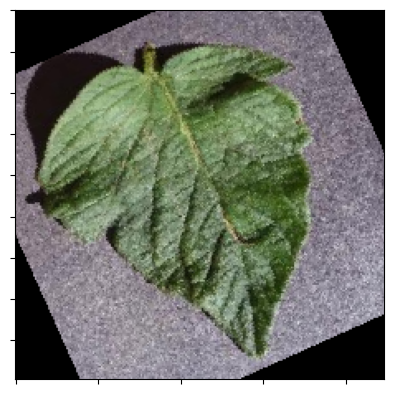

In [21]:
folder = 'Tomato___healthy'
file = '3eaf72d6-be20-4929-b6dc-58f6c9edf2bd___RS_HL 0031_flipTB.JPG'
image = f"{data_dir}/val/{folder}/{file}"
predict_file(image, model)

[0.9260930418968201, 0.0408933199942112, 0.024879394099116325, 0.0025633361656218767, 0.002464676508679986]
['Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot']


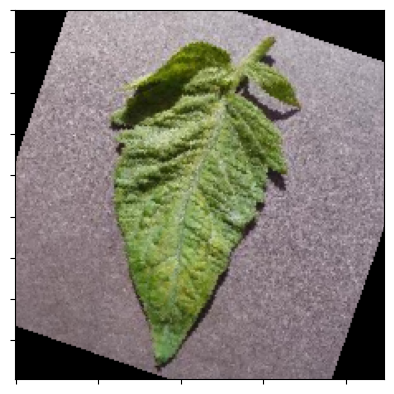

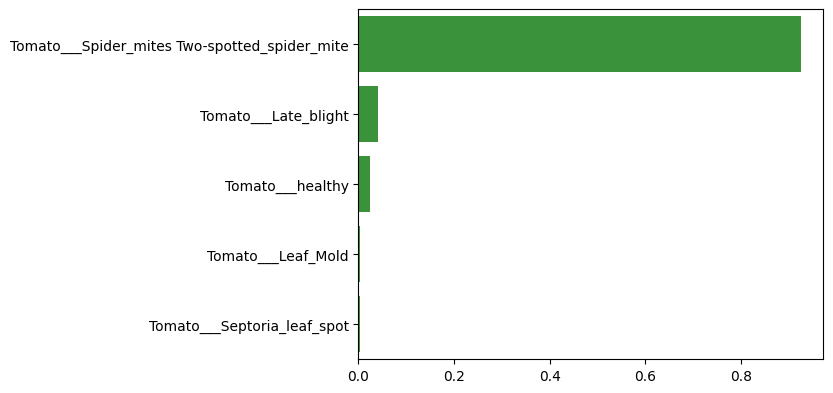

In [20]:
folder = 'Tomato___Spider_mites Two-spotted_spider_mite'
file = '3cf4bee8-cd23-461c-b1c4-1d857b37ad76___Com.G_SpM_FL 1223_180deg.JPG'
image = f"{data_dir}/val/{folder}/{file}"
predict_file(image, model)

[0.9999997615814209, 2.1923918325228442e-07, 1.1521608556108731e-08, 9.053764959965349e-10, 8.813723084699632e-10]
['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Early_blight', 'Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot']


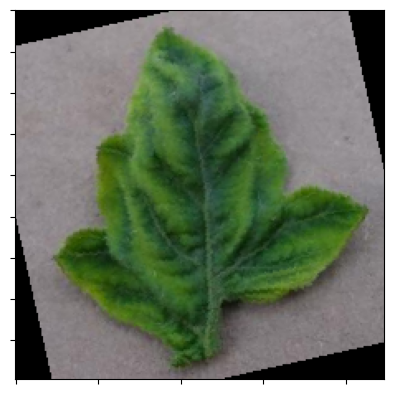

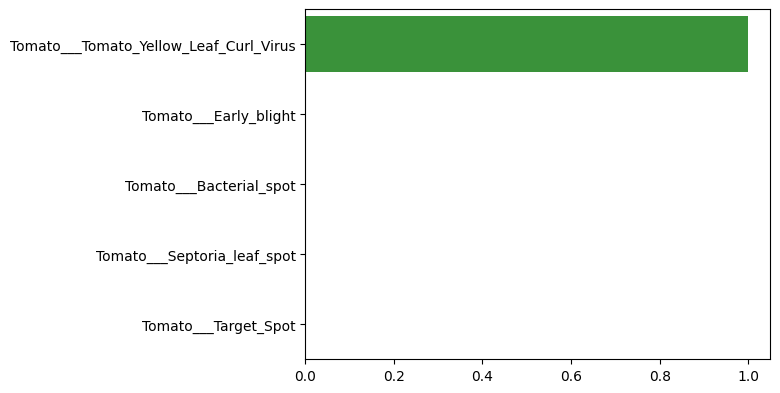

In [21]:
folder = 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
file = '599329fe-867f-402a-8d37-a0c351fc2d03___YLCV_GCREC 2822.JPG'
image = f"{data_dir}/val/{folder}/{file}"
predict_file(image, model)

[0.9977491497993469, 0.0021879547275602818, 4.72764513688162e-05, 8.649002666061278e-06, 6.896947525092401e-06]
['Tomato___Early_blight', 'Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Septoria_leaf_spot']


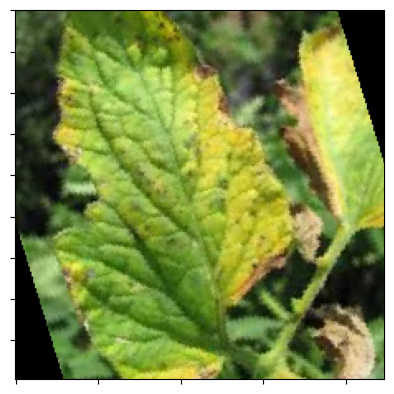

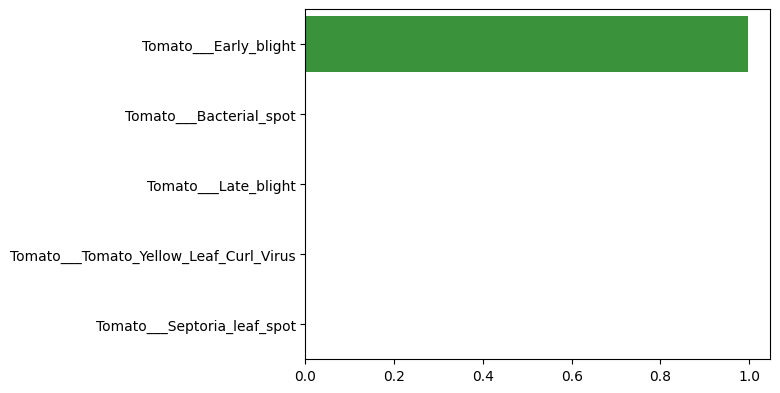

In [22]:
# test

file = 'image_bacterial_spot.jpg'
image = f"dataset/test/{file}"
predict_file(image, model)

[0.9999951124191284, 3.545002527971519e-06, 8.86273426203843e-07, 2.775699385892949e-07, 1.2637909208024212e-07]
['Tomato___healthy', 'Tomato___Leaf_Mold', 'Tomato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot']


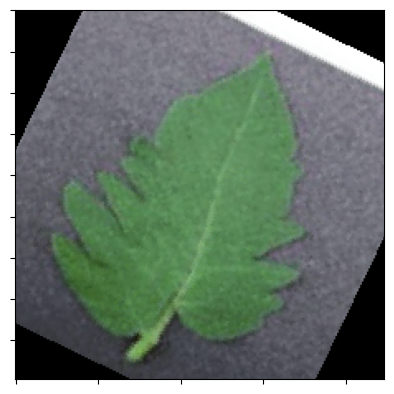

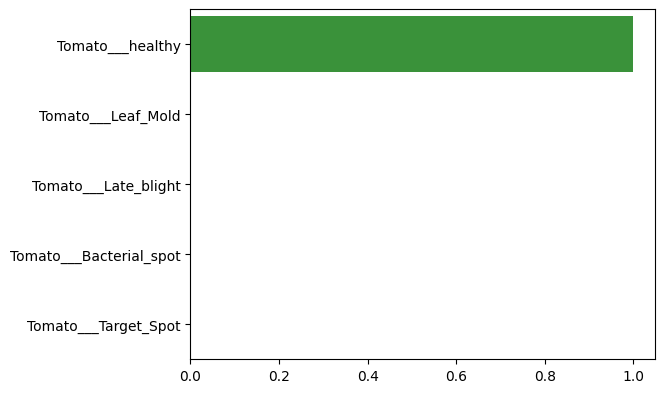

In [23]:
# test

file = 'image_healthy.jpg'
image = f"{data_dir}/test/{file}"
predict_file(image, model)

[0.9966163039207458, 0.003338481765240431, 3.364967051311396e-05, 8.531874300388154e-06, 1.3274338925839402e-06]
['Tomato___Late_blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


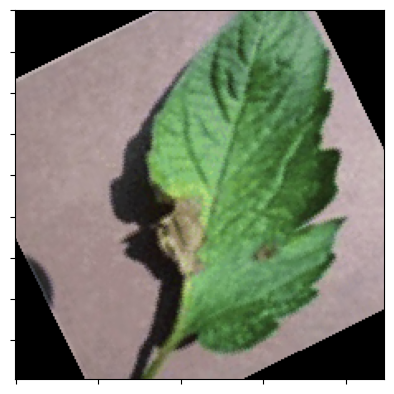

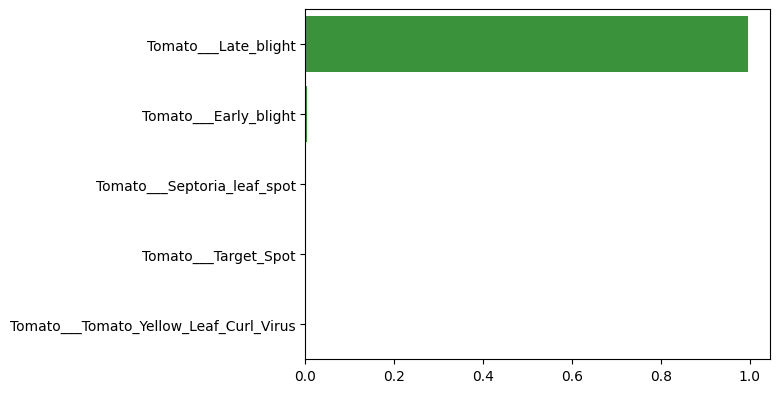

In [24]:
# test

#folder = 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
file = 'image_late_blight.jpg'
image = f"dataset/test/{file}"
predict_file(image, model)

In [27]:
import os

accuracy = total = 0

true_list = []
pred = []

for (root, dirs, files) in os.walk(data_dir + "\\val"):
    if len(files) == 0:
        continue

    folder = root.split("\\")[-1]

    fol_acc = fol_tot = 0
    
    for file in files:
        image = f"{data_dir}/val/{folder}/{file}"
        ps, classes = predict(image, model, False)
        if classes[0] == folder:
            accuracy += 1
            fol_acc += 1

        true_list.append(folder)
        pred.append(classes[0])
        total += 1
        fol_tot += 1

    print(f"{folder}: {fol_acc}/{fol_tot} OR {fol_acc/fol_tot :.2f}")

print("\n")
print(f"FINAL: {accuracy}/{total} OR {accuracy/total :.2f}")

Tomato___Bacterial_spot: 418/425 OR 0.98
Tomato___Early_blight: 457/480 OR 0.95
Tomato___healthy: 480/481 OR 1.00
Tomato___Late_blight: 436/463 OR 0.94
Tomato___Leaf_Mold: 457/470 OR 0.97
Tomato___Septoria_leaf_spot: 397/436 OR 0.91
Tomato___Spider_mites Two-spotted_spider_mite: 408/435 OR 0.94
Tomato___Target_Spot: 370/457 OR 0.81
Tomato___Tomato_mosaic_virus: 442/448 OR 0.99
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 480/490 OR 0.98


FINAL: 4345/4585 OR 0.95


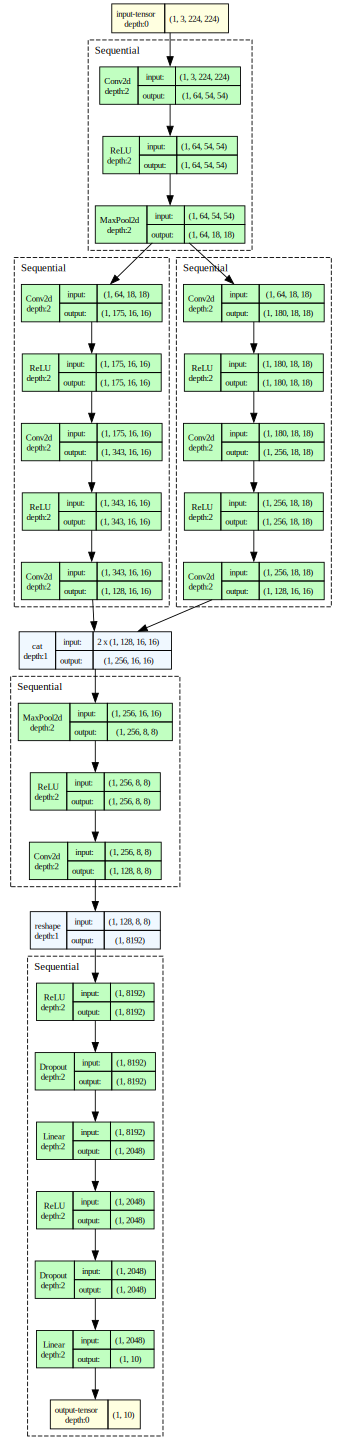

In [63]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 3, 224, 224), device=device, expand_nested=True, save_graph=False, filename="customCNN-LR")
model_graph.visual_graph.node_attr["fontname"] = "Times-Roman"
model_graph.visual_graph

In [28]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["final_accuracy"]["custom_cnn"] = accuracy/total

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

[Text(0.5, 23.38159722222222, 'Pred'), Text(77.78159722222226, 0.5, 'Truth')]

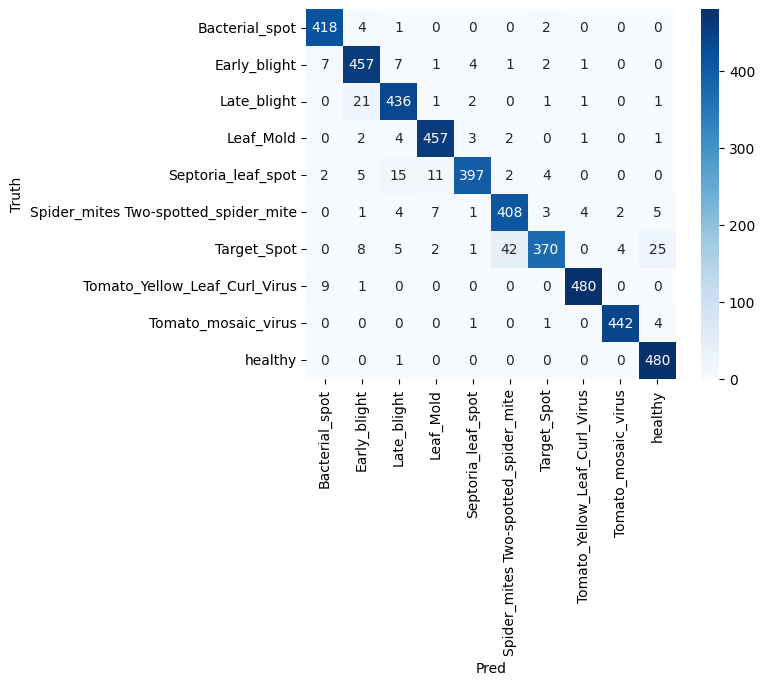

In [51]:
from sklearn.metrics import confusion_matrix

classes_list = list(sorted(model.class_to_idx.keys()))

matrix_confusion = confusion_matrix(true_list, pred, labels=classes_list)

classes_list = [i[9:] for i in classes_list]
ax = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', xticklabels=classes_list, yticklabels=classes_list)
#sns.heatmap(glue, annot=True)
ax.set(xlabel="Pred", ylabel="Truth")

In [54]:
import torchmetrics
pred_tensor, truth_tensor = torch.Tensor([model.class_to_idx[i] for i in pred]), torch.Tensor([model.class_to_idx[i] for i in true_list])

acc = torchmetrics.functional.accuracy(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
precision = torchmetrics.functional.precision(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
recall = torchmetrics.functional.recall(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
f1 = torchmetrics.functional.f1_score(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))

(acc, precision, recall, f1)

(tensor(0.9472), tensor(0.9486), tensor(0.9472), tensor(0.9469))

In [53]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["confusion_matrix"]["custom_cnn"] = np.array(matrix_confusion).tolist()
stats["metrics"]["accuracy"]["custom_cnn"] = float(acc)
stats["metrics"]["precision"]["custom_cnn"] = float(precision)
stats["metrics"]["recall"]["custom_cnn"] = float(recall)
stats["metrics"]["f1_score"]["custom_cnn"] = float(f1)


with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

In [31]:
model

CropDetectCNN3(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_0): Sequential(
    (0): Conv2d(64, 175, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(175, 343, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(343, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer2_1): Sequential(
    (0): Conv2d(64, 180, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(180, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  )
  (layer3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU(inplace=True)


torch.Size([64, 3, 11, 11])


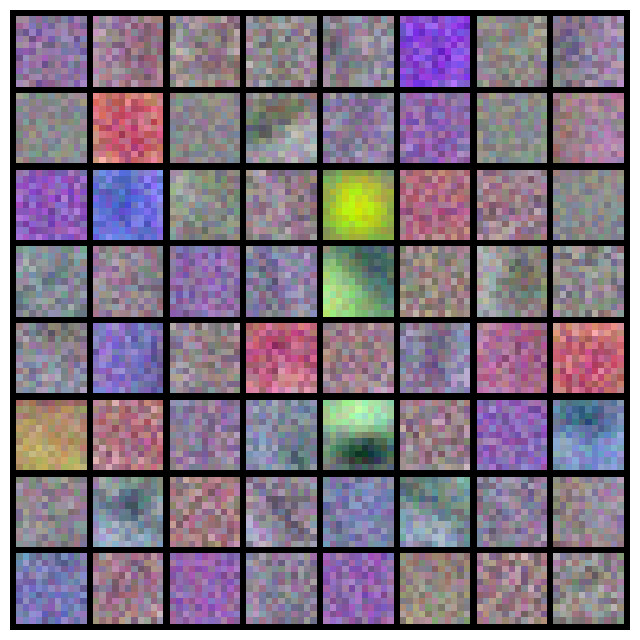

In [21]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt


def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    nrow = int(tensor.shape[0] ** (1/2))
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    '''
    savetensor: save tensor
        @filename: file name
        @ch: visualization channel 
        @allkernels: visualization all tensores
    '''    

    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )


model.to(torch.device('cpu'))
kernel = model.layer1[0].weight.data.clone()
model.to(torch.device(device))
print(kernel.shape)

vistensor(kernel, ch=0, allkernels=False)
#savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

Tomato___Septoria_leaf_spot
[0.9943591952323914, 0.005531017668545246, 9.137901361100376e-05, 1.832947600632906e-05, 1.2844788344068547e-08]
['Tomato___Septoria_leaf_spot', 'Tomato___Early_blight', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot', 'Tomato___Leaf_Mold']


<Figure size 400x400 with 0 Axes>

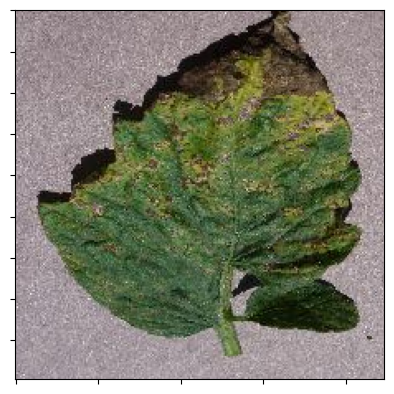

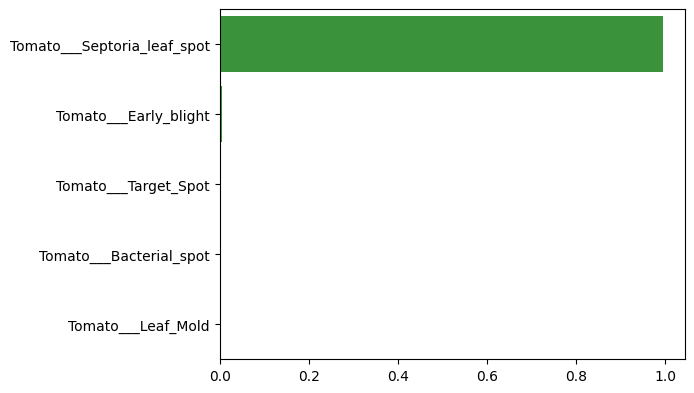

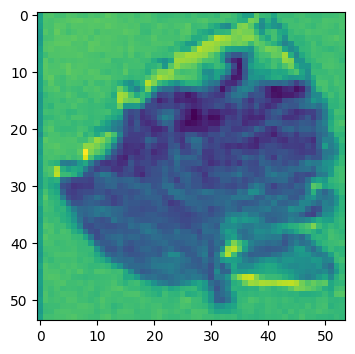

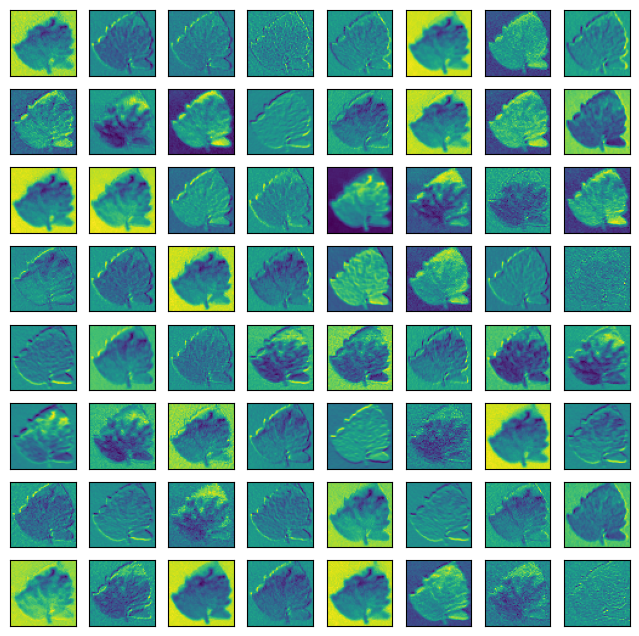

''

In [62]:
from torch.autograd import Variable

plt.figure(figsize =(4,4))
# Plot the original grayscale image
#image = image_numpy_arr.transpose(1, 2, 0)
#print(np.array(images[0]).transpose(1, 2, 0))

id_ = 0

model.to(device)
print(classes[id_])
ps, classes = predict(images[id_], model)
ps = ps.cpu().detach().numpy().tolist()[0]
print(ps)
print(classes)
plot_solution(1, ps, classes)

model.to(torch.device('cpu'))
img = Variable(images[id_].unsqueeze(0), requires_grad=True)

"""
def predict(image, model, show=True):
    with torch.no_grad():
        model.eval()
        image = process_image(image, show)
        image_inp = image.unsqueeze(0)
        
        image_inp = image_inp.to(device)
        
        outputs = model(image_inp)
"""

# Squeeze tensor to numpy image
y = model.layer1[0](img)
#y = model.layer1[1](y)
#y = model.layer1[2](y)

#y2 = model.layer2_0(y)

#y = model.layer2_1(y)

#y = torch.cat([y2, y], 1)
#y = model.layer3(y)
"""
out = torch.cat([out1, out], 1)
out = self.layer3(out)
#print(out.shape)
out = out.reshape(out.size(0), -1)
"""

img_conv1 = y.detach().numpy()
img_conv1 = np.squeeze(img_conv1)

fig = plt.figure(figsize=(4, 4))
plt.imshow(img_conv1.mean(axis=0))
plt.show()

#plt.subplot(1,2,2)
#plt.imshow(img_conv1[0])
#plt.axis('off')
#plt.title('After convolutions')

nrow = int(img_conv1.shape[0] ** (1/2)) if img_conv1.shape[0] < 121 else int(121 ** 0.5)
fig = plt.figure(figsize=(8, 8))

for i in range(img_conv1.shape[0] if img_conv1.shape[0] < 121 else 121):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(nrow, nrow, i+1)
    plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    plt.imshow(img_conv1[i])

plt.show()

model.to(device)
""